In [2]:
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore")

Get Technical Features

In [3]:
sp1500 = pd.read_excel("../data/SPR as of Feb 12 20251.xlsx")
tickers = sp1500['Ticker'].str.split(" ").str[0]

In [4]:
import sys
import os

# Get the absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Get the parent directory of the current working directory

# Construct the path to the `src` directory
src_path = os.path.join(project_root, "src")

# Add the `src` directory to the Python module search path
sys.path.append(src_path)


In [5]:
import importlib
from Features import technical_features_new

importlib.reload(technical_features_new)
from Features.technical_features_new import BuildFeatures

In [6]:
# Generate all NYSE trading days from 1980 to 2025
all_dates = pd.bdate_range(start="1980-01-01", end="2025-02-24", freq="B") 
date_to_qid = {date: qid for qid, date in enumerate(all_dates)}

In [53]:
import pickle as pkl
import gzip
from tqdm import tqdm

# Define storage path
cache_path = "../data/technical_features"

# Ensure the directory exists
os.makedirs(cache_path, exist_ok=True)

# Process stock data
for tick in tqdm(tickers, desc="Processing Tickers", unit="ticker"):
    try:
        obj = BuildFeatures(tick)
    except:
        continue
    
    obj.build_technical_features()  # Compute technical indicators
    data = obj.technical_features.copy()
        
    if data.empty:
        continue
    
    data["Close"] = obj.stock["Close"]
    data = data.resample('BM').last()
    data["Return"] = data["Close"].pct_change().shift(-1).astype(np.float32)

    # Define file path
    file_path = os.path.join(cache_path, f"{tick}.pkl.gz")

    # Save the data using gzip compression to reduce file size
    with gzip.open(file_path, "wb") as f:
        pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)

print("✅ All data has been successfully stored and optimized with compression!")


Processing Tickers: 100%|██████████| 1506/1506 [22:14<00:00,  1.13ticker/s] 

✅ All data has been successfully stored and optimized with compression!


In [5]:
import importlib
from Features import fundamental_features_new

importlib.reload(fundamental_features_new)
from Features.fundamental_features_new import BuildFeatures as BuildFundamentalFeatures

In [6]:
zacks_fc = pd.read_csv("../data/fundamental_data/ZACKS_FC.csv", delimiter=',')
zacks_fc['per_end_date'] = pd.to_datetime(zacks_fc['per_end_date'])
zacks_fc['per_end_date'] = zacks_fc['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fc = zacks_fc.sort_values('per_end_date').set_index('per_end_date')

zacks_fr = pd.read_csv("../data/fundamental_data/ZACKS_FR.csv", delimiter=',')
zacks_fr['per_end_date'] = pd.to_datetime(zacks_fr['per_end_date'])
zacks_fr['per_end_date'] = zacks_fr['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fr = zacks_fr.sort_values('per_end_date').set_index('per_end_date')

zack_data = {}
zack_data["zacks_fc"] = zacks_fc
zack_data["zacks_fr"] = zacks_fr


In [24]:
from tqdm import tqdm
import pickle as pkl
import gzip

# Define storage path
cache_path = "../data/fundamental_features"

# Ensure the directory exists
os.makedirs(cache_path, exist_ok=True)

for tick in tqdm(tickers, desc="Processing Tickers", unit="ticker"):

    try:
        obj = BuildFundamentalFeatures(zack_data, tick)
    except:
        continue

    obj.process_financial_statements()  # Generate technical features for the ticker
    
    # Merge technical features with the calculated returns
    data = obj.fundamental_features.copy()
    
    if data.empty:
        continue

    data = data[data['per_type'] == 'Q']
    data['filing_date'] = pd.to_datetime(data['filing_date'])
    data.index.name = 'report_date'
    data = data.reset_index()
    
    data = data.set_index('filing_date')
    data['filing_date'] = data.index
    try:
        full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq="D")
    except:
        continue
    
    data = data.drop_duplicates(subset="filing_date", keep="last")
    data = data.reindex(full_date_range)
    data = data.ffill().resample('BM').last()
    
    data["Close"] = obj.stock['Close']
    
    data["Return"] = data["Close"].pct_change().shift(-1)
    
    # Define file path
    file_path = os.path.join(cache_path, f"{tick}.pkl.gz")

    # Save the data using gzip compression to reduce file size
    with gzip.open(file_path, "wb") as f:
        pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)

print("✅ All data has been successfully stored and optimized with compression!")

Processing Tickers: 100%|██████████| 133/133 [01:40<00:00,  1.33ticker/s]

✅ All data has been successfully stored and optimized with compression!


In [15]:
from tqdm import tqdm
import gzip
import pickle as pkl

# Set cutoff dates for training, validation, and test sets
train_cutoff = "2014-01-01"
valid_cutoff = "2018-01-01"

# Paths
data_path_tech = "../data/technical_features"
data_path_fin = "../data/fundamental_features"


# List to store all data
all_data = []

# Process all tickers
for tick in tqdm(tickers, desc="Processing Tickers", unit="ticker"):
    
    file_path_tech = os.path.join(data_path_tech, f"{tick}.pkl.gz")
    file_path_fin = os.path.join(data_path_fin, f"{tick}.pkl.gz")
    try:
        # Load technical data
        with gzip.open(file_path_tech, "rb") as f:
            tech_data = pkl.load(f)
            tech_data["Ticker"] = tick  # Add ticker label

        # Load fundamental data
        with gzip.open(file_path_fin, "rb") as f:
            fin_data = pkl.load(f)
            # **Step 1: Drop columns where all values are NaN**
            fin_data = fin_data.dropna(axis=1, how="all")
            # **Step 2: Drop columns that contain string (non-numeric) values**
            fin_data = fin_data.select_dtypes(include=[float, int])  # Keeps only numeric columns

        combined_data = tech_data.merge(fin_data, how="outer", left_index=True, right_index=True)
        combined_data['Return'] = combined_data['Return_x'].fillna(combined_data['Return_y'])
        combined_data = combined_data.drop(columns=['Return_x','Return_y',])
        combined_data = combined_data.dropna(subset = ['Return'])
        combined_data = combined_data.ffill()
        combined_data.index.name = 'date'
    except:
        continue
    
    all_data.append(combined_data)

# **Step 1: Merge all data and sort by date**
all_data_df = pd.concat(all_data).sort_index()

# Remove rows where 'Return' is NaN
all_data_df = all_data_df.dropna(subset=["Return"])

# **Step 1: Define the threshold for missing values**
threshold = len(all_data_df) * 0.3  # Drop columns with less than 10% non-NaN values

# **Step 2: Drop columns that contain too few valid data points**
all_data_df = all_data_df.dropna(axis=1, thresh=threshold)

# **Step 3: Drop rows that still have missing values**
all_data_df = all_data_df.dropna()


# **Step 2: Assign incremental `qid` values based on unique dates**
unique_dates = all_data_df.index.unique()
date_to_qid = {date: i for i, date in enumerate(unique_dates)}  # Incremental mapping
all_data_df["qid"] = all_data_df.index.map(date_to_qid).astype(np.int32)

# **Step 3: Compute quintile ranking for each day's stock returns**
def compute_ranked_labels(df):
    """ Assign quintile ranking to stock returns for each date """
    df["Ranked_Return"] = df.groupby("qid")["Return"].transform(
        lambda x: pd.qcut(x, 5, labels=False, duplicates="drop")  # 0-4 ranking
    ).astype(np.int32)
    return df

all_data_df = compute_ranked_labels(all_data_df)

# **Step 4: Split dataset into train, validation, and test sets**
train_data = all_data_df[all_data_df.index < train_cutoff]
valid_data = all_data_df[(all_data_df.index >= train_cutoff) & (all_data_df.index < valid_cutoff)]
test_data = all_data_df[all_data_df.index >= valid_cutoff]

# **Step 5: Extract features and labels**
def extract_features_labels(df):
    """ Helper function to extract X, y, qid """
    X = df.drop(columns=["Return", "Ranked_Return", "qid", "Ticker"]).values
    y = df["Ranked_Return"].values
    qid = df["qid"].values
    return X, y, qid

X_train, y_train, qid_train = extract_features_labels(train_data)
X_valid, y_valid, qid_valid = extract_features_labels(valid_data)
X_test, y_test, qid_test = extract_features_labels(test_data)

# **Step 5: Save dataset in compressed format**
dataset = {
    "train": (X_train, y_train, qid_train),
    "valid": (X_valid, y_valid, qid_valid),
    "test": (X_test, y_test, qid_test),
}

Processing Tickers: 100%|██████████| 1506/1506 [00:07<00:00, 195.84ticker/s]


In [16]:
train_data

,SMA_50,SMA_200,Chaikin_ADI_Line,Chaikin_ADI_Oscillator,ADM_Index,ADM_Index_Rating,Absolute_Price_Oscillator,Average_True_Range,Average_Price,Bollinger_Band_Upper,...,ret_tang_equity,ret_asset,ret_invst,free_cash_flow_per_share,book_val_per_share,oper_cash_flow_per_share,Return,invty_turn,qid,Ranked_Return
date,,,,,,,,,,,,,,,,,,,,,
2006-02-28,15.33200000,13.89725000,35694442.18063941,91228.65258966,25.35514525,36.79358752,-0.05583333,0.47791313,16.03000000,16.27547308,...,2.41990000,1.00750000,1.41570000,0.77180000,9.88180000,1.00040000,0.06583072,1.34770000,0,4
2006-02-28,19.20660200,17.81895050,1069356673.00502253,-23599627.24155426,15.68530035,15.76167221,0.05910256,0.55219325,18.37000000,19.47512271,...,1.73280000,1.27370000,1.57330000,0.23030000,5.46310000,0.26070000,-0.04421397,0.99680000,0,0
2006-02-28,71.97160000,67.03685000,438409553.58438098,4785522.14336479,24.49164491,28.19244280,1.74865385,1.51875810,76.54250000,79.25579046,...,3.89010000,0.67730000,1.17340000,-2.20820000,14.66320000,-2.01870000,0.03644945,1.06030000,0,2
2006-03-31,32.50201200,28.60320250,846904709.04579687,-10708486.39048505,19.77473777,20.83434176,0.01243205,0.70205423,32.81250000,33.37768382,...,8.05490000,1.64890000,3.21020000,0.52680000,12.67470000,0.63810000,-0.01307291,2.58390000,1,2
2006-03-31,52.11420000,47.87300000,444613212.18066710,-692077.86039019,33.43222658,32.54255965,0.93621795,0.88566130,54.27750000,54.92612251,...,3.26720000,1.72460000,3.08450000,0.94780000,19.30440000,1.98470000,0.00498523,2.87640000,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,23.86968000,23.88908500,83951649.97777064,-277073.59899661,23.96710745,20.88114992,0.39666667,0.34746347,24.79500000,24.88584604,...,2.82440000,1.57350000,2.64850000,0.88260000,10.37890000,2.33680000,0.05378083,14.48740000,94,4
2013-12-31,113.52980000,101.14055000,52545743.84874333,496158.07538851,28.77101118,25.00405409,1.89493590,2.17070903,121.64500000,123.04307636,...,8.08720000,4.34030000,5.62220000,0.36730000,16.96160000,4.09160000,-0.00434177,1.54950000,94,3
2013-12-31,23.53580000,22.99215000,97713948.74885438,136505.74604152,20.58611291,16.26541757,0.33980769,0.34837407,24.17750000,24.26157083,...,3.98280000,1.08340000,1.70410000,0.95950000,22.03260000,3.87150000,0.02197347,2.58110000,94,3


In [32]:
# test_data = all_data[(all_data.index >= valid_cutoff) &  (all_data.index < "2024-03-30")]

# # **Step 5: Extract features and labels**
# def extract_features_labels(df):
#     """ Helper function to extract X, y, qid """
#     X = df.drop(columns=["Return", "Ranked_Return", "qid", "Ticker"]).values
#     y = df["Ranked_Return"].values
#     qid = df["qid"].values
#     return X, y, qid

# X_test, y_test, qid_test = extract_features_labels(test_data)

# # **Step 5: Save dataset in compressed format**
# dataset = {
#     "train": (X_train, y_train, qid_train),
#     "valid": (X_valid, y_valid, qid_valid),
#     "test": (X_test, y_test, qid_test),
# }

In [17]:
import xgboost as xgb

# Load dataset
(train, valid, test) = (dataset['train'], dataset['valid'], dataset['test'])

# Unpack dataset
X_train, y_train, qid_train = train
X_valid, y_valid, qid_valid = valid
X_test, y_test, qid_test = test

# Initialize XGBoost Ranker with appropriate parameters
ranker = xgb.XGBRanker(
    tree_method="hist",  # Use "gpu_hist" if GPU acceleration is available
    device="cpu",
    lambdarank_pair_method="topk",
    lambdarank_num_pair_per_sample=13,
    eval_metric=["ndcg@1", "ndcg@5"],  
    num_boost_round=1000,
    early_stopping_rounds=50  # Stop training if no improvement for 50 rounds
)

# Train the model
ranker.fit(
    X_train,
    y_train,
    qid=qid_train,
    eval_set=[(X_valid, y_valid)],
    eval_qid=[qid_valid],
    verbose=True,
)

# Retrieve evaluation results
test_eval = ranker.evals_result()
print("✅ Training Completed.")

# Predict on the test set
y_pred = ranker.predict(X_test)

# Create a DataFrame to store predictions
predictions = pd.DataFrame({
    "qid": qid_test,
    "y_true": y_test,
    "y_pred": y_pred
}).sort_values(by="qid")

# Display the first 20 predictions
print(predictions.head(20))

[0]	validation_0-ndcg@1:0.45972	validation_0-ndcg@5:0.39393
[1]	validation_0-ndcg@1:0.48472	validation_0-ndcg@5:0.42581
[2]	validation_0-ndcg@1:0.46944	validation_0-ndcg@5:0.43817
[3]	validation_0-ndcg@1:0.46250	validation_0-ndcg@5:0.43464
[4]	validation_0-ndcg@1:0.43889	validation_0-ndcg@5:0.42957
[5]	validation_0-ndcg@1:0.45556	validation_0-ndcg@5:0.42408
[6]	validation_0-ndcg@1:0.47917	validation_0-ndcg@5:0.45769
[7]	validation_0-ndcg@1:0.44167	validation_0-ndcg@5:0.43735
[8]	validation_0-ndcg@1:0.43333	validation_0-ndcg@5:0.43748
[9]	validation_0-ndcg@1:0.45694	validation_0-ndcg@5:0.42429
[10]	validation_0-ndcg@1:0.46528	validation_0-ndcg@5:0.42810
[11]	validation_0-ndcg@1:0.50417	validation_0-ndcg@5:0.42880
[12]	validation_0-ndcg@1:0.53056	validation_0-ndcg@5:0.44107
[13]	validation_0-ndcg@1:0.57917	validation_0-ndcg@5:0.46091
[14]	validation_0-ndcg@1:0.52361	validation_0-ndcg@5:0.45845
[15]	validation_0-ndcg@1:0.51111	validation_0-ndcg@5:0.45504
[16]	validation_0-ndcg@1:0.56806	v

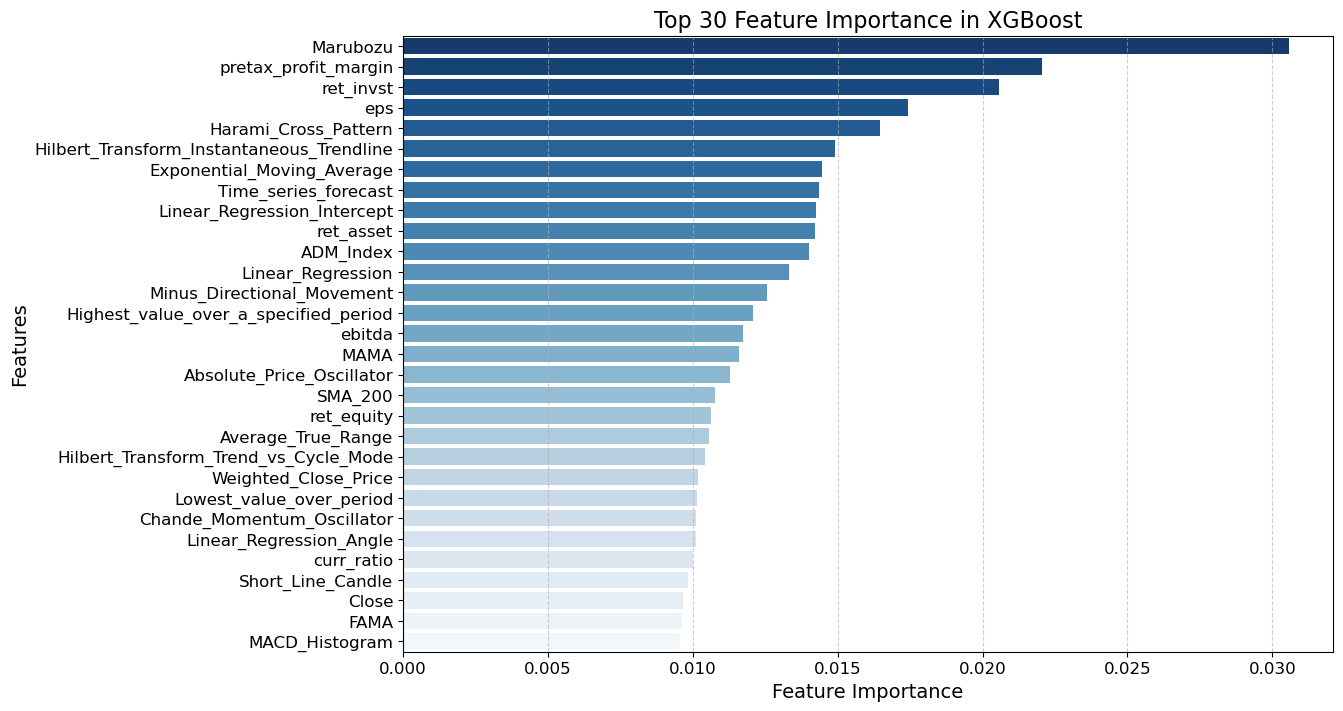

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importance scores
importance = ranker.feature_importances_

# Convert to a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': train_data.drop(columns=["Return", "Ranked_Return", "qid", "Ticker"]).columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# **Limit to Top 30 Features for better readability**
top_n = 30
importance_df = importance_df.head(top_n)

# **Plot Feature Importance**
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")

# **Labeling and Styling**
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title(f"Top {top_n} Feature Importance in XGBoost", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# **Show Grid for better readability**
plt.grid(axis='x', linestyle="--", alpha=0.6)

plt.show()


In [19]:
test_data_selected = test_data.reset_index()[["date", "qid", "Ticker", "Return"]]
predictions['return_true'] = test_data_selected['Return']
predictions["date"] = test_data_selected['date']

In [20]:
predictions

,qid,y_true,y_pred,return_true,date
0,143,0,-0.82048279,-0.10671937,2018-01-31
541,143,0,-0.79844952,-0.20564340,2018-01-31
542,143,1,-0.92311829,-0.09692521,2018-01-31
543,143,1,-1.03658545,-0.08282828,2018-01-31
544,143,4,-0.95242584,0.14625071,2018-01-31
...,...,...,...,...,...
73200,227,2,-0.79121441,-0.03538066,2025-01-31
73201,227,4,-1.11045849,0.05698339,2025-01-31
73202,227,1,-1.18739021,-0.06476042,2025-01-31
73176,227,0,-0.89564443,-0.20742595,2025-01-31


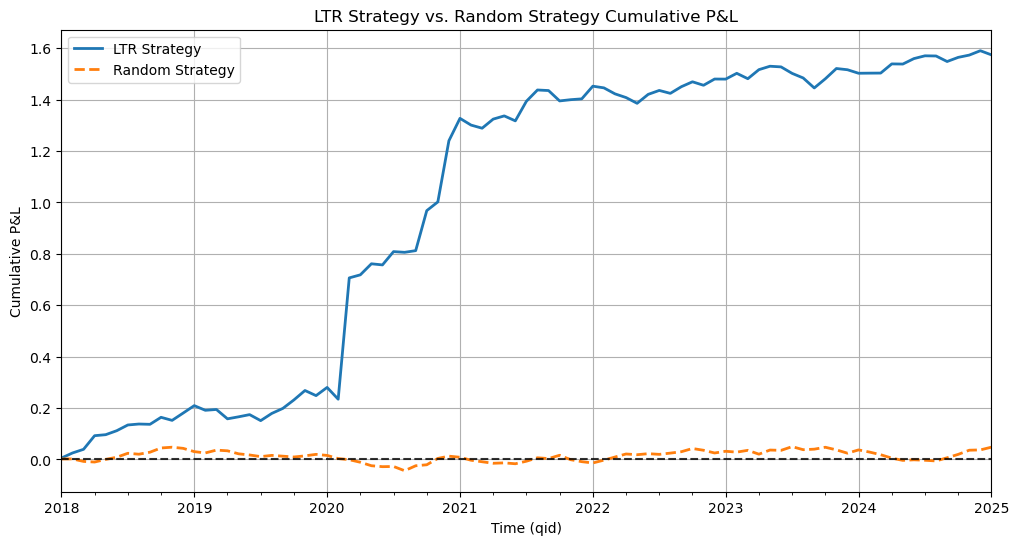

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set parameters
top_k = 50
position_size = 1/(top_k*2)
risk_free_rate = 0.00

# Copy predictions DataFrame
df = predictions.copy()

# **Sort by `qid` (to maintain chronological order)**
df = df.sort_values(by=["qid"])

# **LTR Strategy**
# Step 1: Sort stocks by predicted return `y_pred` within each `qid`
df["rank"] = df.groupby("qid")["y_pred"].rank(ascending=False, method="first")

# Step 2: Select long and short positions
df["long"] = (df["rank"] <= top_k).astype(int)
df["short"] = (df["rank"] > (df.groupby("qid")["rank"].transform("max") - top_k)).astype(int)

# Step 3: Compute returns
df["long_return"] = df["long"] * df["return_true"]
df["short_return"] = -df["short"] * df["return_true"]  # Short positions are negative

# Step 4: Compute daily strategy returns
df["ltr_strategy_return"] = position_size * (df["long_return"] + df["short_return"])

# **Random Strategy**
df["random_long"] = df.groupby("qid")["y_pred"].transform(lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)]))
df["random_short"] = df.groupby("qid")["y_pred"].transform(lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)]))

df["random_long_return"] = df["random_long"] * df["return_true"]
df["random_short_return"] = -df["random_short"] * df["return_true"]

df["random_strategy_return"] = position_size * (df["random_long_return"] + df["random_short_return"])

# **Compute cumulative returns**
monthly_pnl_ltr = df.groupby("date")["ltr_strategy_return"].sum()
monthly_pnl_random = df.groupby("date")["random_strategy_return"].sum()

cumulative_pnl_ltr = monthly_pnl_ltr.cumsum()
cumulative_pnl_random = monthly_pnl_random.cumsum()

# **Compute performance metrics**
def compute_metrics(monthly_pnl, label):
    mean_return = monthly_pnl.mean() * 12  # Annualized return
    std_dev = monthly_pnl.std() * np.sqrt(12)  # Annualized volatility
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan
    return {
        "Strategy": label,
        "Annualized Return": mean_return,
        "Annualized Volatility": std_dev,
        "Sharpe Ratio": sharpe_ratio
    }

ltr_metrics = compute_metrics(monthly_pnl_ltr, "LTR Strategy")
random_metrics = compute_metrics(monthly_pnl_random, "Random Strategy")

performance_df = pd.DataFrame([ltr_metrics, random_metrics])

# **Plot cumulative returns**
plt.figure(figsize=(12, 6))
cumulative_pnl_ltr.plot(label="LTR Strategy", linewidth=2)
cumulative_pnl_random.plot(label="Random Strategy", linewidth=2, linestyle="dashed")

plt.axhline(y=0, color="black", linestyle="--", alpha=0.8)
plt.xlabel("Time (qid)")
plt.ylabel("Cumulative P&L")
plt.title("LTR Strategy vs. Random Strategy Cumulative P&L")
plt.legend()
plt.grid()
plt.show()

In [23]:
performance_df

,Strategy,Annualized Return,Annualized Volatility,Sharpe Ratio
0,LTR Strategy,0.00888854,0.00874167,1.01680175
1,Random Strategy,0.00180033,0.00531511,0.33871859


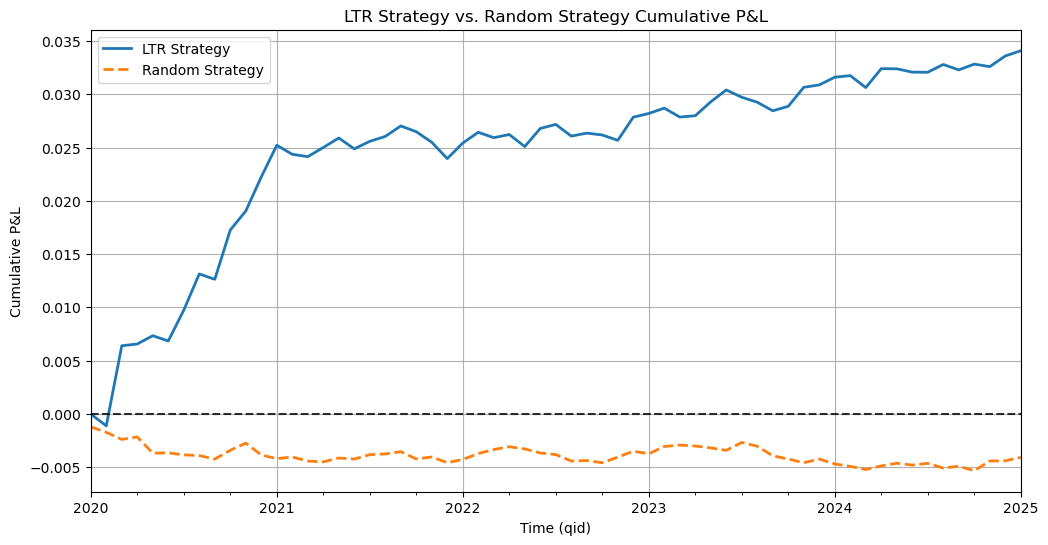

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set parameters
top_k = 50
position_size = 1/(top_k**2)
risk_free_rate = 0.00

# Copy predictions DataFrame
df = predictions.copy()

# **Sort by `qid` (to maintain chronological order)**
df = df.sort_values(by=["qid"])

# **LTR Strategy**
# Step 1: Sort stocks by predicted return `y_pred` within each `qid`
df["rank"] = df.groupby("qid")["y_pred"].rank(ascending=False, method="first")

# Step 2: Select long and short positions
df["long"] = (df["rank"] <= top_k).astype(int)
df["short"] = (df["rank"] > (df.groupby("qid")["rank"].transform("max") - top_k)).astype(int)

# Step 3: Compute returns
df["long_return"] = df["long"] * df["return_true"]
df["short_return"] = -df["short"] * df["return_true"]  # Short positions are negative

# Step 4: Compute daily strategy returns
df["ltr_strategy_return"] = position_size * (df["long_return"] + df["short_return"])

# **Random Strategy**
df["random_long"] = df.groupby("qid")["y_pred"].transform(lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)]))
df["random_short"] = df.groupby("qid")["y_pred"].transform(lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)]))

df["random_long_return"] = df["random_long"] * df["return_true"]
df["random_short_return"] = -df["random_short"] * df["return_true"]

df["random_strategy_return"] = position_size * (df["random_long_return"] + df["random_short_return"])

# **Compute cumulative returns**
monthly_pnl_ltr = df.groupby("date")["ltr_strategy_return"].sum()
monthly_pnl_random = df.groupby("date")["random_strategy_return"].sum()

cumulative_pnl_ltr = monthly_pnl_ltr.cumsum()
cumulative_pnl_random = monthly_pnl_random.cumsum()

# **Compute performance metrics**
def compute_metrics(monthly_pnl, label):
    mean_return = monthly_pnl.mean() * 12  # Annualized return
    std_dev = monthly_pnl.std() * np.sqrt(12)  # Annualized volatility
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan
    return {
        "Strategy": label,
        "Annualized Return": mean_return,
        "Annualized Volatility": std_dev,
        "Sharpe Ratio": sharpe_ratio
    }

ltr_metrics = compute_metrics(monthly_pnl_ltr, "LTR Strategy")
random_metrics = compute_metrics(monthly_pnl_random, "Random Strategy")

performance_df = pd.DataFrame([ltr_metrics, random_metrics])

# **Plot cumulative returns**
plt.figure(figsize=(12, 6))
cumulative_pnl_ltr.plot(label="LTR Strategy", linewidth=2)
cumulative_pnl_random.plot(label="Random Strategy", linewidth=2, linestyle="dashed")

plt.axhline(y=0, color="black", linestyle="--", alpha=0.8)
plt.xlabel("Time (qid)")
plt.ylabel("Cumulative P&L")
plt.title("LTR Strategy vs. Random Strategy Cumulative P&L")
plt.legend()
plt.grid()
plt.show()

In [102]:
df

,qid,y_true,y_pred,return_true,date,rank,long,short,long_return,short_return,ltr_strategy_return,random_long,random_short,random_long_return,random_short_return,random_strategy_return
0,471,2,-0.65274662,-0.10000000,2020-01-31,406.00000000,0,0,-0.00000000,-0.00000000,-0.00000000,0,0,-0.00000000,-0.00000000,-0.00000000
702,471,3,-0.48346215,-0.07688245,2020-01-31,292.00000000,0,0,-0.00000000,-0.00000000,-0.00000000,0,0,-0.00000000,-0.00000000,-0.00000000
1,471,4,-1.03325045,0.00697618,2020-01-31,966.00000000,0,0,0.00000000,0.00000000,0.00000000,0,0,0.00000000,0.00000000,0.00000000
2,471,0,-1.20094836,-0.16902944,2020-01-31,1312.00000000,0,0,-0.00000000,-0.00000000,-0.00000000,0,0,-0.00000000,-0.00000000,-0.00000000
3,471,1,0.33328080,-0.12650603,2020-01-31,34.00000000,1,0,-0.12650603,-0.00000000,-0.00005060,0,0,-0.00000000,-0.00000000,-0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89031,531,0,-0.94137132,-0.13939829,2025-01-31,904.00000000,0,0,-0.00000000,-0.00000000,-0.00000000,0,0,-0.00000000,-0.00000000,-0.00000000
89032,531,3,-0.81880563,0.03049041,2025-01-31,710.00000000,0,0,0.00000000,0.00000000,0.00000000,0,0,0.00000000,0.00000000,0.00000000
89033,531,0,-0.58927959,-0.16887562,2025-01-31,452.00000000,0,0,-0.00000000,-0.00000000,-0.00000000,0,0,-0.00000000,-0.00000000,-0.00000000
89024,531,1,-1.13975513,-0.08762550,2025-01-31,1301.00000000,0,0,-0.00000000,-0.00000000,-0.00000000,0,0,-0.00000000,-0.00000000,-0.00000000


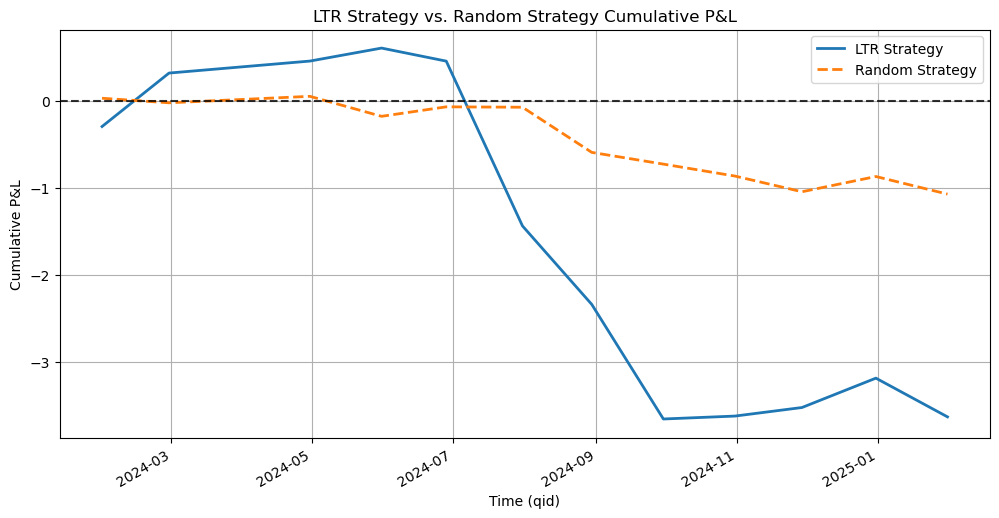

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set parameters
top_k = 50
position_size = 1
risk_free_rate = 0.00

# Copy predictions DataFrame
df = predictions.copy()

# **Sort by `qid` (to maintain chronological order)**
df = df.sort_values(by=["qid"])

# **LTR Strategy**
# Step 1: Sort stocks by predicted return `y_pred` within each `qid`
df["rank"] = df.groupby("qid")["y_pred"].rank(ascending=False, method="first")

# Step 2: Select long and short positions
df["long"] = (df["rank"] <= top_k).astype(int)
df["short"] = (df["rank"] > (df.groupby("qid")["rank"].transform("max") - top_k)).astype(int)

# Step 3: Compute returns
df["long_return"] = df["long"] * df["return_true"]
df["short_return"] = -df["short"] * df["return_true"]  # Short positions are negative

# Step 4: Compute daily strategy returns
df["ltr_strategy_return"] = position_size * (df["long_return"] + df["short_return"])

# **Random Strategy**
df["random_long"] = df.groupby("qid")["y_pred"].transform(lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)]))
df["random_short"] = df.groupby("qid")["y_pred"].transform(lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)]))

df["random_long_return"] = df["random_long"] * df["return_true"]
df["random_short_return"] = -df["random_short"] * df["return_true"]

df["random_strategy_return"] = position_size * (df["random_long_return"] + df["random_short_return"])

# **Compute cumulative returns**
monthly_pnl_ltr = df.groupby("date")["ltr_strategy_return"].sum()
monthly_pnl_random = df.groupby("date")["random_strategy_return"].sum()

cumulative_pnl_ltr = monthly_pnl_ltr.cumsum()
cumulative_pnl_random = monthly_pnl_random.cumsum()

# **Compute performance metrics**
def compute_metrics(monthly_pnl, label):
    mean_return = monthly_pnl.mean() * 12  # Annualized return
    std_dev = monthly_pnl.std() * np.sqrt(12)  # Annualized volatility
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan
    return {
        "Strategy": label,
        "Annualized Return": mean_return,
        "Annualized Volatility": std_dev,
        "Sharpe Ratio": sharpe_ratio
    }

ltr_metrics = compute_metrics(monthly_pnl_ltr, "LTR Strategy")
random_metrics = compute_metrics(monthly_pnl_random, "Random Strategy")

performance_df = pd.DataFrame([ltr_metrics, random_metrics])

# **Plot cumulative returns**
plt.figure(figsize=(12, 6))
cumulative_pnl_ltr.plot(label="LTR Strategy", linewidth=2)
cumulative_pnl_random.plot(label="Random Strategy", linewidth=2, linestyle="dashed")

plt.axhline(y=0, color="black", linestyle="--", alpha=0.8)
plt.xlabel("Time (qid)")
plt.ylabel("Cumulative P&L")
plt.title("LTR Strategy vs. Random Strategy Cumulative P&L")
plt.legend()
plt.grid()
plt.show()


In [53]:
performance_df

,Strategy,Annualized Return,Annualized Volatility,Sharpe Ratio
0,LTR Strategy,2.32745516,1.75170184,1.32868226
1,Random Strategy,0.42326570,0.93471357,0.45282930
